# Adding Uncertainty Estimations to Machine Learning Regression Outputs: Tutorial
### Case study: Cycle Life Prediction
This notebook overviews concepts for adding uncertainty estimations to ML regression outputs, put in the context of battery cycle life predictions. Much of the feature engineering as well as the cycling dataset was introduced by [Severson et al.](https://web.mit.edu/braatzgroup/Severson_NatureEnergy_2019.pdf) in their 2019 Nature Energy publication. Likewise, the structure of this tutorial, especially of the initial concepts surrounding uncertainty estimations, was inspired from this [blog post](https://www.valencekjell.com/posts/2022-09-14-prediction-intervals/).

#### Why Measure Uncertainty?
Machine Learning predictions inherently have some error or uncertainty. Uncertainty can stem from the model choice - the inability for a simple model to capture true behavior - as well as from data input - both due to a lack of quality or quantity of data (read more about these types of uncertainty [here](https://towardsdatascience.com/with-mapie-uncertainties-are-back-in-machine-learning-882d5c17fdc3)). Understanding the level of uncertainty of a ML model is critical for a few reasons:
1. **Trust** Humans are more likely to trust what they can understand. Black-box ML models which spit out a prediction with no indication of the level of uncertainty breed distrust and confusion from users when those predictions do not line up with reality.
1. **Limitations** All ML models have limitations in their ability to predict values given a current dataset. Uncertainty estimations can provide information on where a model is more likely to perform well - specifically in areas with a high density of relatively noiseless data. Note, even uncertainty estimations are dependent on the input data, so care still needs to be taken to understand or determine limitations that might extend beyond the provided data, such as the (in)ability to [extrapolate to data with different degradation modes](https://www.frontiersin.org/articles/10.3389/fenrg.2022.1058999).
1. **Risk** ML models are increasingly integrated into important decision-making processes. Quantifying model uncertainty can provide one measure of risk in this endeavor.

#### Goal
Our goal is to identify methods for **estimating uncertainty** of a machine learning model. Our models will be predicting the number of cycles a cell will last before reaching a specified capacity retention threshold. In this example, we will be using an 85% capacity retention threshold, as referenced from cycle 20.

Our uncertainty estimation will be generated in the form of a **prediction interval**. Users can set a target interval threshold, most commonly set to 95%. This means that ~95% of the time a target prediction will fall within the given prediction interval. The larger the prediction interval, the more uncertain your estimated performance is.

#### Methods for Measuring Uncertainty
The possible options for uncertainty estimation of a ML regression model are:
1. Use a model for which prediction intervals can be calculated explictly (we will show this for the linear regression case)
1. Use a model which inherently integrates uncertainty estimations and thus returns prediction intervals
1. Use a method which enables you to calculate prediction intervals on any ML model

The segments of this tutorial are as follows:
1. [Data Preparation](#Data-Preparation)
1. [Linear regression prediction interval calculation](#Linear-Regression)
1. ML models with inherent prediction interval calculations:
    1. [Bayesian Ridge Regression](#Bayesian-Ridge-Regression), 
    1. [Gaussian Process Regression](#Gaussian-Process-Regression)
    1. [Gradient Boosting Regression](#Gradient-Boosting-Regression) (quantile regression)
1. [Model Agnostic Prediction Interval Estimator (MAPIE)](#MAPIE), and application to:
    1. [Linear Regression](#MAPIE-Linear-Regression), and [Elastic Net](#MAPIE-Elastic-Net)
    1. [Bayesian Ridge Regression](#MAPIE-Bayesian-Ridge-Regression)
    1. [Gaussian Process Regression](#MAPIE-Gaussian-Process-Regression)
    1. [Gradient Boosting Regression](#MAPIE-Gradient-Boosting-Regression)

Here is what the cycling performance of the Severson dataset looks like (taken from the manuscript). We are looking to predict the cycle at which an individual cell will have reached 85% of its initial capacity retention, using this cycling data as input training data.
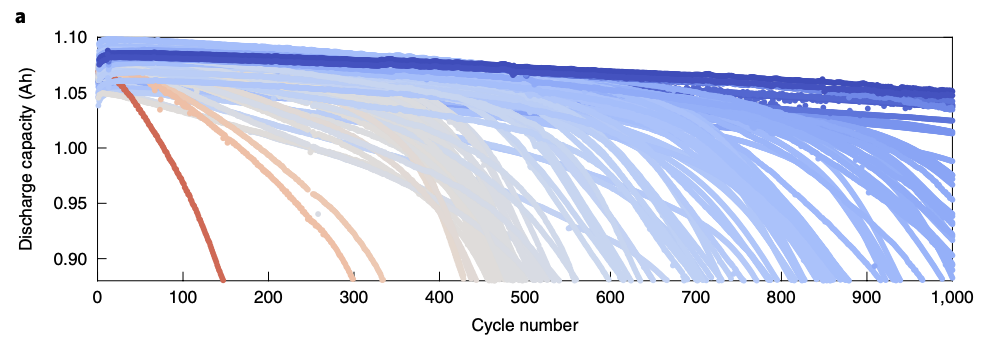

In [1]:
pip install mapie

Note: you may need to restart the kernel to use updated packages.


In [2]:
import voltaiq_studio as vs
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def make_figure(y_train, predicted_train_cycle_life, y_test1, predict_test1, train_error = [], test_error = [], name = "Regression"):
    """ Function for plotting parity plots with or without error bars"""
    if (len(train_error) == 0) or (len(test_error) == 0):
        plt.scatter(10**y_train,10**predicted_train_cycle_life, alpha = 0.6, label="Train")
        plt.scatter(10**y_test1,10**predict_test1, alpha = 0.6, label="Test")
    else:
        plt.errorbar(x = 10**y_train,
                        y = 10**predicted_train_cycle_life,
                        yerr = train_error, capsize = 3,linestyle='',
                        label = 'Train', alpha = 0.6,marker='o')
        plt.errorbar(x = 10**y_test1,
                        y = 10**predict_test1,
                        yerr = test_error, capsize = 3,linestyle='',
                        label = 'Test', alpha = 0.6,marker='o')
    min_axis = 10**min([min(y_train),min(predicted_train_cycle_life),min(y_test1),min(predict_test1)])
    max_axis = 10**max([max(y_train),max(predicted_train_cycle_life),max(y_test1),max(predict_test1)])
    plt.plot([min_axis,max_axis],[min_axis,max_axis],'k')
    plt.xlabel('Observed cycle life')
    plt.ylabel('Predicted cycle life')
    plt.title("Parity plot for " + name + " model")
    plt.legend()
    plt.axis('square')
    plt.show()
    
def get_mape(y_train, predicted_train_cycle_life, y_test1, predict_test1,name):
    """ Function that return the Mean Absolute Percentage Error for the train the test sets"""
    print(f"MAPE results for {name} model:")
    train_mape = 100*mean_absolute_percentage_error(np.power(10, y_train), np.power(10, predicted_train_cycle_life))
    train_rmse = mean_squared_error(np.power(10, y_train), np.power(10, predicted_train_cycle_life), squared=False)
    print("Training mean absolute percentage error: ", train_mape, "%")
    print("Training root mean squared error: ", train_rmse, " cycles")

    test1_mape = 100*mean_absolute_percentage_error(np.power(10, y_test1), np.power(10, predict_test1))
    test1_rmse = mean_squared_error(np.power(10, y_test1), np.power(10, predict_test1), squared=False)
    print("Test1 mean absolute percentage error: ", test1_mape, "%")
    print("Test1 root mean squared error: ", test1_rmse, " cycles")
    return [train_mape, test1_mape]

## Data Preparation
In this section, we will load in the Severson dataset and split the data into a train and test group. For more information on the features, exploratory data analysis, and a basic walk-through of linear regression techniques please look at our [Cycle Life Prediction Tutorial](https://www.voltaiqcommunity.com/editions/studio?showcase=1451ae38-7d1f-47ce-87cd-7699861a9bab)

In [4]:
load_name = 'dataset2022-12-05 14_53_30.896552'
with open(load_name, "rb") as f:
    data = pickle.load(f)
    
# We will add in the log cycle life target variable
data['log_cyc_life'] = np.log10(data.cyc_life)

#### Manually split training and testing data

In [5]:
train_data = data[data.Dataset_group == 'Severson2019 - Train (LFP)'].copy()
X_train = train_data.drop(columns = ['cyc_life','Dataset_group','log_cyc_life'])
y_train = train_data.log_cyc_life
X_train.head()

,min_deltaQ,mean_deltaQ,var_deltaQ,skew_deltaQ,kur_deltaQ,deltaQ_lowV,slope_22_99,intcpt_22_99,slope_90_99,intcpt_90_99,q_22,maxQ_q_22,q_99
Name,,,,,,,,,,,,,
2017-05-12_3_6C-80per_3_6C_CH2_VDF,-2.070144,-2.455492,-5.028018,-0.427786,-1.869674,-0.002186,-0.000017,1.082534,-0.000029,1.083580,1.081923,0.608978,1.080649
2017-05-12_4C-80per_4C_CH5_VDF,-1.840401,-2.218537,-4.632537,-0.526915,0.097271,-0.002521,-0.000007,1.085825,-0.000007,1.085408,1.085078,0.007000,1.084765
2017-05-12_4_4C-80per_4_4C_CH7_VDF,-1.657452,-2.032932,-4.293405,-0.725104,0.064739,-0.004419,-0.000011,1.081323,-0.000024,1.082180,1.080456,0.001615,1.079788
2017-05-12_4_8C-80per_4_8C_CH9_VDF,-1.547026,-1.950946,-4.041558,-0.335869,0.064054,-0.003491,-0.000024,1.098508,-0.000033,1.099141,1.096267,0.001701,1.095874
2017-05-12_5_4C-50per_3C_CH14_VDF,-1.589375,-2.030320,-4.108288,-0.228045,0.051376,-0.003403,-0.000008,1.061089,-0.000014,1.061318,1.060326,0.002914,1.059947


In [6]:
print('Length training data: ', len(X_train))
print('Total dataset length: ', len(data))

Length training data:  41
Total dataset length:  209


In [7]:
test_data_1 = data[data.Dataset_group == 'Severson2019 - Test (LFP)'].copy()
y_test1 = test_data_1.log_cyc_life
X_test1 = test_data_1.drop(columns=['cyc_life','log_cyc_life','Dataset_group'])
print("Length test data: ", len(X_test1))

Length test data:  43


## Linear Regression
In this section we will evaluate a simple linear regressor on our train data, and then calculate a prediction interval.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [9]:
pipe =  Pipeline([('scaler', StandardScaler()), ('lin_regress', LinearRegression())])
pipe.fit(np.array(X_train), np.ravel(y_train))
predicted_train_cycle_life = pipe.predict(np.array(X_train))
predict_test1 = pipe.predict(np.array(X_test1))

In [10]:
lr_mape = get_mape(y_train, predicted_train_cycle_life, y_test1, predict_test1,name = "Linear Regression")
mape_df = pd.DataFrame({"linear regression":lr_mape},index = ["Train","Test"])

MAPE results for Linear Regression model:
Training mean absolute percentage error:  7.65267665459082 %
Training root mean squared error:  65.47017771758539  cycles
Test1 mean absolute percentage error:  29.72604921931246 %
Test1 root mean squared error:  499.2991248776263  cycles


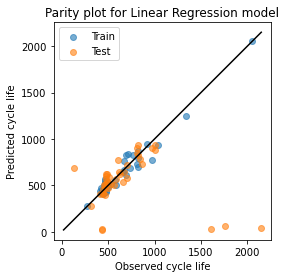

In [11]:
make_figure(y_train, predicted_train_cycle_life, y_test1, predict_test1, name = "Linear Regression")

While the plot above shows explicit predicted cycle lives for each battery, the model contains uncertainty because it is estimating a linear best-fit to a noisy dataset. We can visualize this by plotting the standard deviation of the sum of squares.



In [12]:
# Compute prediction intervals
sum_of_squares_train = np.sum((np.array(10**y_train) - 10**predicted_train_cycle_life) ** 2)
std_train = np.sqrt(1 / (len(y_train) - 2) * sum_of_squares_train)
y_err_train = np.vstack([[std_train]*len(y_train), [std_train]*len(y_train)]) * 1.96

sum_of_squares_test = np.sum((np.array(10**y_test1) - 10**predict_test1) ** 2)
std_test = np.sqrt(1 / (len(y_test1) - 2) * sum_of_squares_test)
y_err_test = np.vstack([[std_test]*len(y_test1), [std_test]*len(y_test1)]) * 1.96

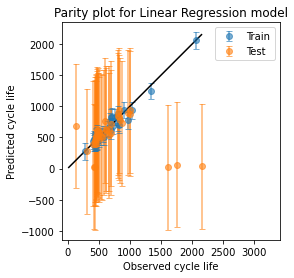

In [13]:
make_figure(y_train, predicted_train_cycle_life, y_test1, predict_test1, y_err_train, y_err_test, name = "Linear Regression")

Note that we can tell the Linear Regression model does not perform well for some of the Test data, where the predicted cycle life is around zero. In the Severson publication, they use an Elastic Net model which limits overfitting and provide better model performance.

In [14]:
from sklearn.linear_model import ElasticNetCV
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

pipeline =  Pipeline([('scaler', StandardScaler()), ('enet', ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter = 25000))])

pipeline.fit(X_train, y_train)
enet_train = pipeline.predict(X_train)
enet_test = pipeline.predict(X_test1)

In [15]:
enet_mape = get_mape(y_train, enet_train, y_test1, enet_test, name = "Enet Regression")
mape_df['elastic net'] = enet_mape

MAPE results for Enet Regression model:
Training mean absolute percentage error:  10.362722956698017 %
Training root mean squared error:  77.1418973585995  cycles
Test1 mean absolute percentage error:  14.129251075535027 %
Test1 root mean squared error:  111.485404562081  cycles


The Test errors are lower than for the standard Linear Regression model, which is good. We can visualize this on a parity plot:

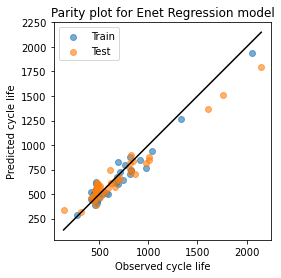

In [16]:
make_figure(y_train, enet_train, y_test1, enet_test, name = "Enet Regression")

We can perform the same estimation of prediction intervals as with pure linear regression:

In [17]:
# Compute prediction intervals
sum_of_squares_train_enet = np.sum((np.array(10**y_train) - 10**enet_train) ** 2)
std_train_enet = np.sqrt(1 / (len(y_train) - 2) * sum_of_squares_train_enet)
y_err_train_enet = np.vstack([[std_train_enet]*len(y_train), [std_train_enet]*len(y_train)]) * 1.96

sum_of_squares_test_enet = np.sum((np.array(10**y_test1) - 10**enet_test) ** 2)
std_test_enet = np.sqrt(1 / (len(y_test1) - 2) * sum_of_squares_test_enet)
y_err_test_enet = np.vstack([[std_test_enet]*len(y_test1), [std_test_enet]*len(y_test1)]) * 1.96

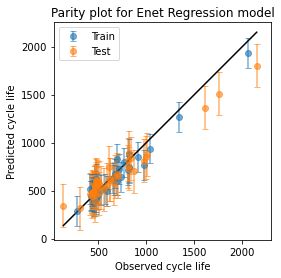

In [18]:
make_figure(y_train, enet_train, y_test1, enet_test, y_err_train_enet, y_err_test_enet, name = "Enet Regression")

**Summary**

Note that these prediction estimates are the same for ALL datapoints in the training set (and in the test set). This is due to the limitation of using a sum of squared error method for estimating prediction intervals. Ideally, we would like a customized prediction interval for each data point (aka battery) that takes into account its input features and how similar they are to the input features of the training dataset, as well as inherent uncertainty within the model. To do this, we must move away from simple linear regression models.

## ML models with inherent prediction interval calculations
There are a number of ML models that provide prediction intervals through their design; these are Bayesian methods which infer probability distributions of each output rather than just presenting a single output value. A few examples are compared below.

### Bayesian Ridge Regression

[Bayesian Ridge Regression](https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression) builds off of ridge regression, which incorporates regularization to simplify a model by limiting the importance of many input features. The Bayesian approach is to estimate the ridge regression `lambda` parameter from the data assuming that the output data is Gaussian distributed. 

Inherent to Bayesian Ridge Regression is the ability to estimate output uncertainty through returning a standard deviation of the posterior distribution of the model parameters. The following code was developed by referencing the [sklearn documentation for BRR](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html), and an [example sklearn tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ard.html#id2)

In [19]:
from sklearn.linear_model import BayesianRidge
pipe_brr =  Pipeline([('scaler', StandardScaler()), 
                      ('brr', BayesianRidge())])

pipe_brr.fit(X_train, y_train)

y_train_brr, y_train_brr_std = pipe_brr.predict(X_train, return_std=True)
y_test_brr, y_test_brr_std = pipe_brr.predict(X_test1, return_std=True)

# the standard deviations are different from 95% confidence intervals; 
# a 95% confidence interval essentially encompasses 2 standard deviations
# we therefore multiply the std by two, and also convert it from log cycle life to cycle life

upper_lim_brr_train = 10**(2*y_train_brr_std + y_train_brr)
lower_lim_brr_train = 10**(-2*y_train_brr_std + y_train_brr)
upper_lim_brr_test = 10**(2*y_test_brr_std + y_test_brr)
lower_lim_brr_test = 10**(-2*y_test_brr_std + y_test_brr)

y_train_brr_err = np.abs([lower_lim_brr_train,upper_lim_brr_train] - 10**y_train_brr)
y_test_brr_err = np.abs([lower_lim_brr_test,upper_lim_brr_test] - 10**y_test_brr)

In [20]:
brr_mape = get_mape(y_train, y_train_brr, y_test1, y_test_brr, name = "Bayesian Ridge Regression")
mape_df['bayesian ridge'] = brr_mape

MAPE results for Bayesian Ridge Regression model:
Training mean absolute percentage error:  9.185223075517971 %
Training root mean squared error:  73.25855960086955  cycles
Test1 mean absolute percentage error:  17.24741880358829 %
Test1 root mean squared error:  168.90639419855344  cycles


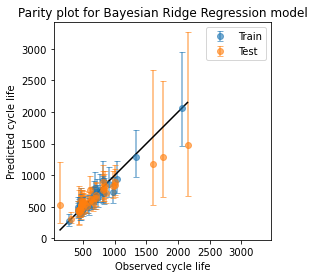

In [21]:
make_figure(y_train, y_train_brr, y_test1, y_test_brr,y_train_brr_err, y_test_brr_err, name = "Bayesian Ridge Regression")

This shows reasonable error bars that encompass the unity line in the parity plot, with higher uncertainty in sparse regions.

It is important to note that Scikit-Learn does mention that adjusting the hyperparameters can be very important for BRR (e.g. see this [tutorial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_bayesian_ridge_curvefit.html#sphx-glr-auto-examples-linear-model-plot-bayesian-ridge-curvefit-py)) which states "In general, when fitting a curve with a polynomial by Bayesian ridge regression, the selection of initial values of the regularization parameters (alpha, lambda) may be important. This is because the regularization parameters are determined by an iterative procedure that depends on initial values."

### Gaussian Process Regression

[Gaussian Process Regression](https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process) is another technique which inherently provides information about the distribution of an output prediction. To learn more about how GPR works, a nice resource is this arxiv preprint on [An Intuitive Tutorial to Gaussian Processes Regression](https://arxiv.org/pdf/2009.10862.pdf), as well as this [blog post](https://yugeten.github.io/posts/2019/09/GP/). Additional documentation on how to implement the scikit-learn version can be found in their [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html), as well as in these tutorials:
- [This tutorial](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-targets-py) illustrates a simple example of adding noise estimations and identifying the 95% confidence interval.
- [This tutorial](https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-noisy-py) illustrates the importance of selecting an appropriate kernel and initialization parameters. The following example illustrates a single default kernel choice which is described in the linked tutorial.

In [22]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel #, Constant

kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
) # the WhiteKernel represents the noise in the data
pipe_gpr =  Pipeline([('scaler', StandardScaler()), 
                      ('gpr', GaussianProcessRegressor(kernel = kernel))])

pipe_gpr.fit(X_train, y_train)

y_train_gpr, y_train_gpr_std = pipe_gpr.predict(X_train, return_std=True)
y_test_gpr, y_test_gpr_std = pipe_gpr.predict(X_test1, return_std=True)

# the standard deviations are different from 95% confidence intervals; 
# a 95% confidence interval essentially encompasses 2 standard deviations
# we therefore multiply the std by two, and also convert it from log cycle life to cycle life

upper_lim_gpr_train = 10**(2*y_train_gpr_std + y_train_gpr)
lower_lim_gpr_train = 10**(-2*y_train_gpr_std + y_train_gpr)
upper_lim_gpr_test = 10**(2*y_test_gpr_std + y_test_gpr)
lower_lim_gpr_test = 10**(-2*y_test_gpr_std + y_test_gpr)

y_train_gpr_err = np.abs([lower_lim_gpr_train,upper_lim_gpr_train] - 10**y_train_gpr)
y_test_gpr_err = np.abs([lower_lim_gpr_test,upper_lim_gpr_test] - 10**y_test_gpr)

In [23]:
gpr_mape = get_mape(y_train, y_train_gpr, y_test1, y_test_gpr, name = "Gaussian Process Regression")
mape_df['gaussian process'] = gpr_mape

MAPE results for Gaussian Process Regression model:
Training mean absolute percentage error:  9.235377344861567 %
Training root mean squared error:  73.22865049045166  cycles
Test1 mean absolute percentage error:  15.88981838526091 %
Test1 root mean squared error:  161.4088325324834  cycles


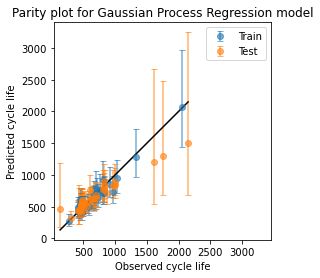

In [24]:
make_figure(y_train, y_train_gpr, y_test1, y_test_gpr,y_train_gpr_err, y_test_gpr_err, name = "Gaussian Process Regression")

These values look visually identical to the BRR case, suggesting both methods are similar in their error estimation.

### Gradient Boosting Regression
Prediction intervals can also be calculated for Gradient Boosting Regression, as seen in this [tutorial](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html) from scikit-learn, which is reproduced in part below.

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error


all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    pipe_grad_boost =  Pipeline([('scaler', StandardScaler()), 
                      ('grad_boost', GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params))])
    all_models["q %1.2f" % alpha] = pipe_grad_boost.fit(X_train, y_train)
    
gbr_ls = Pipeline([('scaler', StandardScaler()), 
                      ('grad_boost', GradientBoostingRegressor(loss="squared_error", **common_params))])
all_models["mse"] = gbr_ls.fit(X_train, y_train)

y_train_mean = all_models["mse"].predict(X_train) # this is what we would normally output and plot
y_train_lower = all_models["q 0.05"].predict(X_train)
y_train_upper = all_models["q 0.95"].predict(X_train)
y_train_med = all_models["q 0.50"].predict(X_train) # this is the median value, which can differ from the mean in skewed distributions
y_train_err = np.abs([10**y_train_lower, 10**y_train_upper] - 10**y_train_mean)


y_test_mean = all_models["mse"].predict(X_test1) # this is what we would normally output and plot
y_test_lower = all_models["q 0.05"].predict(X_test1)
y_test_upper = all_models["q 0.95"].predict(X_test1)
y_test_med = all_models["q 0.50"].predict(X_test1) # this is the median value, which can differ from the mean in skewed distributions
y_test_err = np.abs([10**y_test_lower, 10**y_test_upper] - 10**y_test_mean)


In [26]:
gbr_mape = get_mape(y_train, y_train_mean, y_test1, y_test_mean, name = "Gradient Boosting Regression")
mape_df['gradient boosting'] = gbr_mape

MAPE results for Gradient Boosting Regression model:
Training mean absolute percentage error:  6.029249881286316 %
Training root mean squared error:  115.8778304469612  cycles
Test1 mean absolute percentage error:  17.522411745767148 %
Test1 root mean squared error:  262.23800369802996  cycles


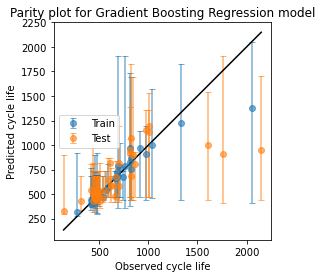

In [27]:
make_figure(y_train, y_train_mean, y_test1, y_test_mean,y_train_err, y_test_err, name = "Gradient Boosting Regression")

Gradient Boosting Regression shows larger errors compared with BRR and GPR especially for the longer cycle life data where the data predictions are farther away from the observed cycle life. Thus, while this model seems to fit the data more poorly, we are also getting feedback of this poorer fit from the error bars.

#### Summary of Model performance
We can compare the mean absolute percentage error performance of all the models thus far, and determine that from this perspective the elastic net seems to perform the best, however, it is unclear whether the error estimations we used above are truly representative of the uncertainty surrounding each datapoint.

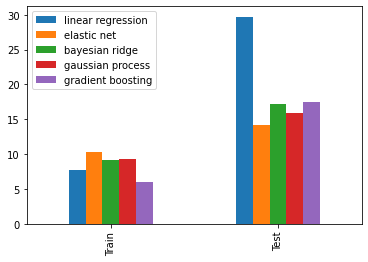

In [28]:
_ = mape_df.plot.bar()

## MAPIE
The above examples illustrate that there are specific ML models that can be used to estimate prediction error. However, many of these models are complex and require significant tuning. Additionally, they might not be the model that you are looking to use for your ML task. An alternative approach is described below, which enables you to use almost any ML model (with scikit-learn compatible APIs) and estimate prediction uncertainty from statistical methods.


**MAPIE (Model Agnostic Prediction Interval Estimator)** is a python package which "allows you to easily estimate prediction intervals (or prediction sets) using your favourite scikit-learn-compatible model for single-output regression or multi-class classification settings.

Prediction intervals output by MAPIE encompass both aleatoric and epistemic uncertainties and are backed by strong theoretical guarantees thanks to conformal prediction methods.

**How does MAPIE work on regression?** It is basically based on cross-validation and relies on:
- Conformity scores on the whole training set obtained by cross-validation,
- Perturbed models generated during the cross-validation.

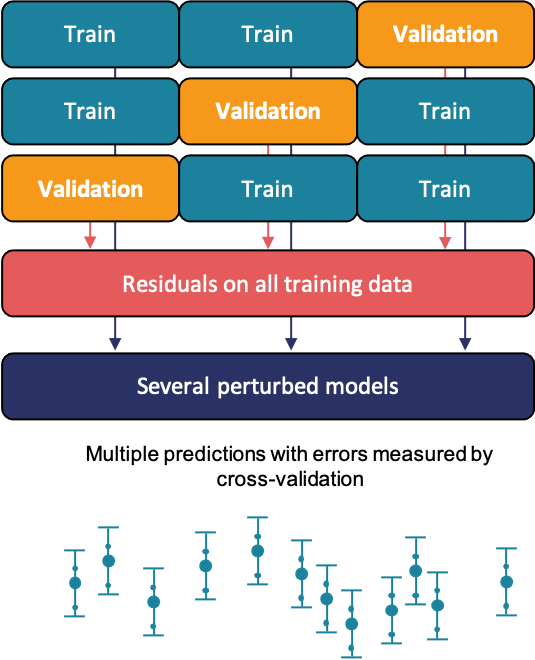

MAPIE then combines all these elements in a way that provides prediction intervals on new data with strong theoretical guarantees [1-2]."

More information can be found at their [GitHub](https://github.com/scikit-learn-contrib/MAPIE), and in their [documentation](https://mapie.readthedocs.io/en/latest/index.html). This [introductory blog post](https://towardsdatascience.com/with-mapie-uncertainties-are-back-in-machine-learning-882d5c17fdc3) also provides some motivation and good introduction to the MAPIE technique

Additional references:
1. Rina Foygel Barber, Emmanuel J. Candès, Aaditya Ramdas, and Ryan J. Tibshirani. “Predictive inference with the jackknife+.” Ann. Statist., 49(1):486–507, February 2021.
1. Byol Kim, Chen Xu, and Rina Foygel Barber. “Predictive Inference Is Free with the Jackknife+-after-Bootstrap.” 34th Conference on Neural Information Processing Systems (NeurIPS 2020).

In [29]:
from mapie.regression import MapieRegressor

### MAPIE Linear Regression
We will begin by illustrating the ability to obtain prediction intervals from a linear regressor using MAPIE.

In [30]:
lin_regress_pipe =  Pipeline([('scaler', StandardScaler()), ('lin_regress', LinearRegression())])
mapie = MapieRegressor(lin_regress_pipe, method="plus", cv=10)

mapie.fit(X_train, y_train)

lr_train_predict, lr_train_pis = mapie.predict(X_train, alpha=[0.05])
lr_test_predict, lr_test_pis = mapie.predict(X_test1, alpha=[0.05])

lr_train_lower_bounds = lr_train_pis[:, 0, 0].T
lr_train_upper_bounds = lr_train_pis[:, 1, 0].T
lr_test_lower_bounds = lr_test_pis[:, 0, 0].T
lr_test_upper_bounds = lr_test_pis[:, 1, 0].T
lr_train_y_err = np.abs([10**lr_train_lower_bounds, 10**lr_train_upper_bounds] - 10**lr_train_predict)
lr_test_y_err = np.abs([10**lr_test_lower_bounds, 10**lr_test_upper_bounds] - 10**lr_test_predict)



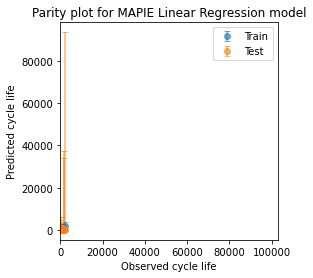

In [31]:
make_figure(y_train, lr_train_predict, y_test1, lr_test_predict,lr_train_y_err, lr_test_y_err, name = "MAPIE Linear Regression")

There are some huge error bars on the Test dataset as returned by the MAPIE result. Recall the original figure:

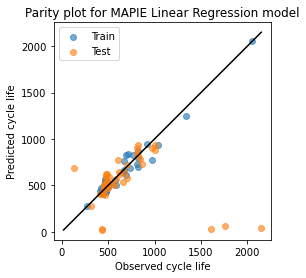

In [32]:
make_figure(y_train, lr_train_predict, y_test1, lr_test_predict , name = "MAPIE Linear Regression")

Let's remove the data points that predict very low cycle life in the Test dataset and replot the parity plot to show that most of the data has reasonable error, but as expected the test predictions that are very different from the true observed values have extremely high error.

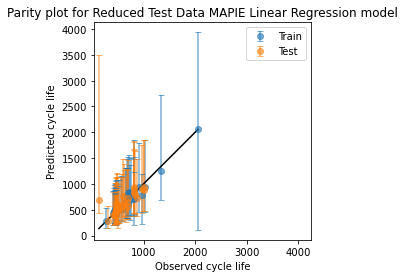

In [33]:
lr_test_df = pd.DataFrame({'y_test1':y_test1,'lr_test_predict':lr_test_predict, 'lr_test_y_err_lower':lr_test_y_err[0],'lr_test_y_err_upper':lr_test_y_err[1]})
lr_test_df_remove_low = lr_test_df[lr_test_df.lr_test_predict > 2]
make_figure(y_train, lr_train_predict, lr_test_df_remove_low.y_test1, lr_test_df_remove_low.lr_test_predict,lr_train_y_err, [lr_test_df_remove_low.lr_test_y_err_lower,lr_test_df_remove_low.lr_test_y_err_upper], name = "Reduced Test Data MAPIE Linear Regression")

### MAPIE Elastic Net
Let's compare these results with the Elastic Net model - we will notice much better results here, given that the predicted cycle life values for the Test dataset are much closer to the observed values.

In [34]:
from sklearn.linear_model import ElasticNetCV
l1_ratios = [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]

enet_pipe =  Pipeline([('scaler', StandardScaler()), ('enet', ElasticNetCV(l1_ratio=l1_ratios, cv=5, random_state=0, max_iter = 25000))])

enet_mapie = MapieRegressor(enet_pipe, method="plus", cv=10)

enet_mapie.fit(X_train, y_train)

en_train_predict, en_train_pis = enet_mapie.predict(X_train, alpha=[0.05])
en_test_predict, en_test_pis = enet_mapie.predict(X_test1, alpha=[0.05])

en_train_lower_bounds = en_train_pis[:, 0, 0].T
en_train_upper_bounds = en_train_pis[:, 1, 0].T
en_test_lower_bounds = en_test_pis[:, 0, 0].T
en_test_upper_bounds = en_test_pis[:, 1, 0].T
en_train_y_err = np.abs([10**en_train_lower_bounds, 10**en_train_upper_bounds] - 10**en_train_predict)
en_test_y_err = np.abs([10**en_test_lower_bounds, 10**en_test_upper_bounds] - 10**en_test_predict)


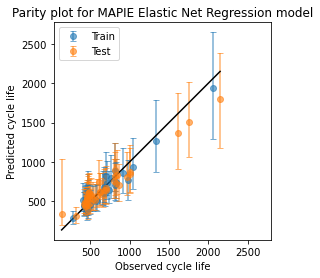

In [35]:
make_figure(y_train, en_train_predict, y_test1, en_test_predict,en_train_y_err, en_test_y_err, name = "MAPIE Elastic Net Regression")

Compare with the estimation using standard squared error (see below), we notice that the error bars more accurately reflect the data scarcity at the low and high observed cycle life.

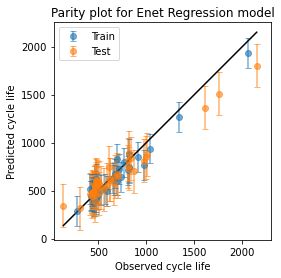

In [36]:
make_figure(y_train, enet_train, y_test1, enet_test, y_err_train_enet, y_err_test_enet, name = "Enet Regression")

### MAPIE Bayesian Ridge Regression

In [37]:
pipe_brr =  Pipeline([('scaler', StandardScaler()), 
                      ('brr', BayesianRidge())])
brr_mapie = MapieRegressor(pipe_brr, method="plus", cv=10)

brr_mapie.fit(X_train, y_train)

brr_train_predict, brr_train_pis = brr_mapie.predict(X_train, alpha=[0.05])
brr_test_predict, brr_test_pis = brr_mapie.predict(X_test1, alpha=[0.05])

brr_train_lower_bounds = brr_train_pis[:, 0, 0].T
brr_train_upper_bounds = brr_train_pis[:, 1, 0].T
brr_test_lower_bounds = brr_test_pis[:, 0, 0].T
brr_test_upper_bounds = brr_test_pis[:, 1, 0].T
brr_train_y_err = np.abs([10**brr_train_lower_bounds, 10**brr_train_upper_bounds] - 10**brr_train_predict)
brr_test_y_err = np.abs([10**brr_test_lower_bounds, 10**brr_test_upper_bounds] - 10**brr_test_predict)


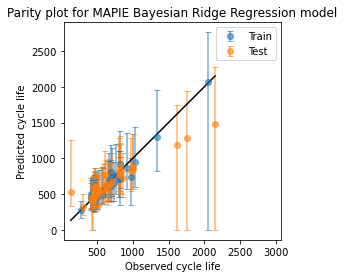

In [38]:
make_figure(y_train, brr_train_predict, y_test1, brr_test_predict, brr_train_y_err, brr_test_y_err, name = "MAPIE Bayesian Ridge Regression")

Compared with the std deviation output from Bayesian Ridge (see below), we have slight changes in the error estimations for the sparse data, with a higher uncertainty of underestimation compared with overestimation.

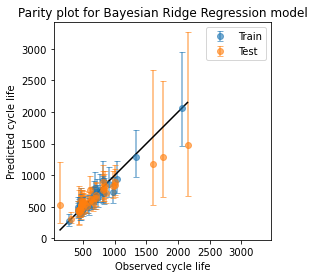

In [39]:
make_figure(y_train, y_train_brr, y_test1, y_test_brr,y_train_brr_err, y_test_brr_err, name = "Bayesian Ridge Regression")

### MAPIE Gaussian Process Regression

In [40]:
kernel = 1.0 * RBF(length_scale=1e-1, length_scale_bounds=(1e-2, 1e3)) + WhiteKernel(
    noise_level=1e-2, noise_level_bounds=(1e-10, 1e1)
) # the WhiteKernel represents the noise in the data
pipe_gpr =  Pipeline([('scaler', StandardScaler()), 
                      ('gpr', GaussianProcessRegressor(kernel = kernel))])

gpr_mapie = MapieRegressor(pipe_gpr, method="plus", cv=10)

gpr_mapie.fit(X_train, y_train)

gpr_train_predict, gpr_train_pis = gpr_mapie.predict(X_train, alpha=[0.05])
gpr_test_predict, gpr_test_pis = gpr_mapie.predict(X_test1, alpha=[0.05])

gpr_train_lower_bounds = gpr_train_pis[:, 0, 0].T
gpr_train_upper_bounds = gpr_train_pis[:, 1, 0].T
gpr_test_lower_bounds = gpr_test_pis[:, 0, 0].T
gpr_test_upper_bounds = gpr_test_pis[:, 1, 0].T
gpr_train_y_err = np.abs([10**gpr_train_lower_bounds, 10**gpr_train_upper_bounds] - 10**gpr_train_predict)
gpr_test_y_err = np.abs([10**gpr_test_lower_bounds, 10**gpr_test_upper_bounds] - 10**gpr_test_predict)

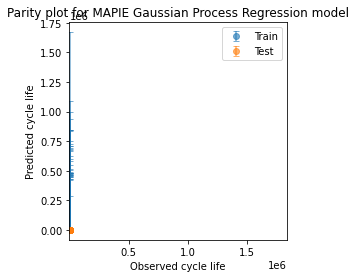

In [41]:
make_figure(y_train, gpr_train_predict, y_test1, gpr_test_predict,gpr_train_y_err, gpr_test_y_err, name = "MAPIE Gaussian Process Regression")

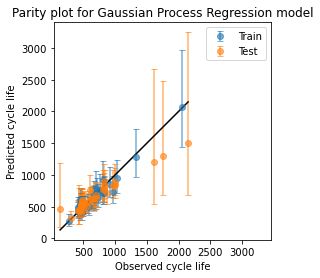

In [42]:
make_figure(y_train, y_train_gpr, y_test1, y_test_gpr,y_train_gpr_err, y_test_gpr_err, name = "Gaussian Process Regression")

It is clear that the uncertainty estimation provided by MAPIE is much larger than that provided by the GPR model itself. In this case, it's likely better to stick with the uncertainty estimation provided by the GPR model.

### MAPIE Gradient Boosting Regression

In [43]:
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
    
gbr_ls = Pipeline([('scaler', StandardScaler()), 
                      ('grad_boost', GradientBoostingRegressor(loss="squared_error", **common_params))])

gbr_mapie = MapieRegressor(gbr_ls, method="plus", cv=10)

gbr_mapie.fit(X_train, y_train)

gbr_train_predict, gbr_train_pis = gbr_mapie.predict(X_train, alpha=[0.05])
gbr_test_predict, gbr_test_pis = gbr_mapie.predict(X_test1, alpha=[0.05])

gbr_train_lower_bounds = gbr_train_pis[:, 0, 0].T
gbr_train_upper_bounds = gbr_train_pis[:, 1, 0].T
gbr_test_lower_bounds = gbr_test_pis[:, 0, 0].T
gbr_test_upper_bounds = gbr_test_pis[:, 1, 0].T
gbr_train_y_err = np.abs([10**gbr_train_lower_bounds, 10**gbr_train_upper_bounds] - 10**gbr_train_predict)
gbr_test_y_err = np.abs([10**gbr_test_lower_bounds, 10**gbr_test_upper_bounds] - 10**gbr_test_predict)

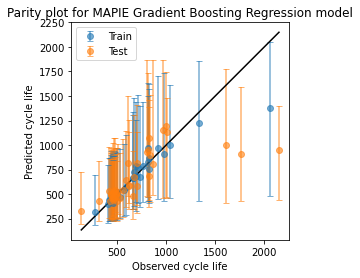

In [44]:
make_figure(y_train, gbr_train_predict, y_test1, gbr_test_predict,gbr_train_y_err, gbr_test_y_err, name = "MAPIE Gradient Boosting Regression")

The error bars for the high and low observed cycle life data obtained via MAPIE are again similar to those obtained via training 4 GBR models. Note that the error bars are higher for the MAPIE estimations in the intermediate regime.

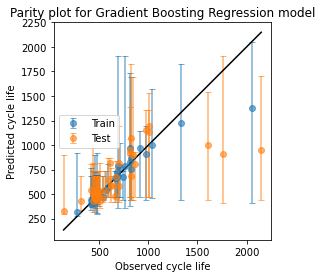

In [45]:
make_figure(y_train, y_train_mean, y_test1, y_test_mean,y_train_err, y_test_err, name = "Gradient Boosting Regression")

## Prediction of Cycle Life on Unseen Data
So the above models seem to perform pretty well on our test dataset as well! At this point, we might decide that we would like to use one of these models to predict the cycle life on another batch of unseen data. In production, this unseen data would not yet have reached the 'end of life' criteria - otherwise there would be no reason to predict the cycle life!

If we want to show uncertainty of data that has not yet reached the set end of life criteria, we would no longer plot the data on a Parity Plot, since we do not have an observed cycle life. However, the error metrics will still be generated in the same way for all of the above techniques, and can be visualized either in text format (e.g. `Predicted cycle life = XX (+Y/ -Z) cycles`, or in a bar chart for each prediction. 

In the following example, we will be looking at how the trained model predicts the performance of two different use cases. The first is for a dataset that was collected at a different time as the original training dataset but is nominally similar - same chemistry (LFP) and similar fast-charge protocols. This data was collected by [Attia et al.](https://www.nature.com/articles/s41586-020-1994-5) We will then try to apply this model to a completely new dataset - specifically for some NMC cells cycling at a 1C rate in a publication by [Weng et al.](https://arxiv.org/abs/2203.14158).

In [46]:
attia_data = data[data.Dataset_group == 'Attia2020 (LFP)'].copy()
weng_data = data[data.Dataset_group == 'Weng2021 (NMC)'].copy()

In [47]:
X_attia = attia_data.drop(columns=['cyc_life','log_cyc_life','Dataset_group'])
y_attia = attia_data.log_cyc_life
X_weng = weng_data.drop(columns=['cyc_life','log_cyc_life','Dataset_group'])
y_weng = weng_data.log_cyc_life

Let's compare the performance for the Elastic Net model, which was already fit in the `pipeline` variable.

In [48]:
attia_predict = pipeline.predict(X_attia)
weng_predict = pipeline.predict(X_weng)

Let's take a look at the predicted cycle lives of these cells

In [49]:
predict_df = pd.DataFrame({'Predicted cycle life':list(10**attia_predict) + list(10**weng_predict),'Group':['Attia2020 (LFP)']*len(attia_predict)+['Weng2021 (NMC)']*len(weng_predict)})

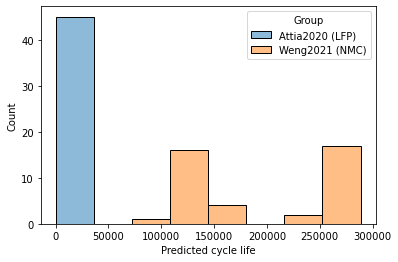

In [50]:
_=sns.histplot(data = predict_df,x = 'Predicted cycle life',hue='Group')

The predictions for the Weng2021 dataset look very wrong. The large numbers are also skewing the histogram for the Attia data. Let's look at that on its own:

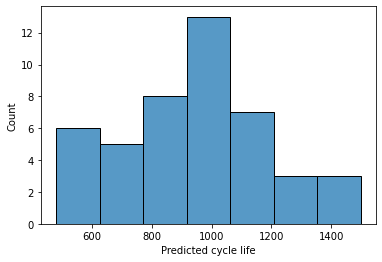

In [51]:
_=sns.histplot(data = predict_df[predict_df.Group == 'Attia2020 (LFP)'],x = 'Predicted cycle life')

Let's use MAPIE to provide us with an uncertainty estimation for these predictions. This will help guide our decision making for determining whether our chosen model is likely providing us with accurate estimates of lifetime (note, we already have an intuitive answer, especially for the Weng2021 dataset, but let's make this a bit more quanitative).

In [52]:
en_weng_predict, en_weng_pis = enet_mapie.predict(X_weng, alpha=[0.05])
en_attia_predict, en_attia_pis = enet_mapie.predict(X_attia, alpha=[0.05])

en_weng_lower_bounds = en_weng_pis[:, 0, 0].T
en_weng_upper_bounds = en_weng_pis[:, 1, 0].T
en_attia_lower_bounds = en_attia_pis[:, 0, 0].T
en_attia_upper_bounds = en_attia_pis[:, 1, 0].T
en_weng_y_err = np.abs([10**en_weng_lower_bounds, 10**en_weng_upper_bounds] - 10**en_weng_predict)
en_attia_y_err = np.abs([10**en_attia_lower_bounds, 10**en_attia_upper_bounds] - 10**en_attia_predict)

Since we actually **DO** have the performance outcomes for these two new datasets, we can still plot the Parity plot as before:

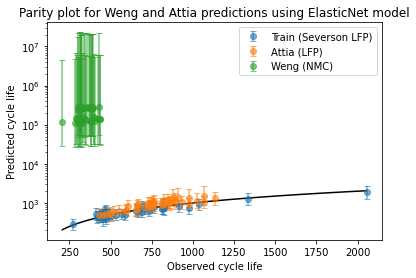

In [53]:
# make_figure(y_train, en_train_predict, y_test1, en_test_predict,en_train_y_err, en_test_y_err, name = "MAPIE Elastic Net Regression")

# plt.scatter(10**y_train,10**en_train_predict, alpha = 0.6, label="Train (Severson LFP)")
plt.errorbar(x = 10**y_train,
                        y = 10**en_train_predict,
                        yerr = en_train_y_err, capsize = 3,linestyle='',
                        label = 'Train (Severson LFP)', alpha = 0.6,marker='o')
# plt.scatter(10**y_attia,10**attia_predict, alpha = 0.6, label="Attia (LFP)")
plt.errorbar(x = 10**y_attia,
                        y = 10**attia_predict,
                        yerr = en_attia_y_err, capsize = 3,linestyle='',
                        label = 'Attia (LFP)', alpha = 0.6,marker='o')
# plt.scatter(10**y_weng,10**weng_predict, alpha = 0.6, label="Weng (NMC)")
plt.errorbar(x = 10**y_weng,
                        y = 10**weng_predict,
                        yerr = en_weng_y_err, capsize = 3,linestyle='',
                        label = 'Weng (NMC)', alpha = 0.6,marker='o')
min_axis = 10**min([min(y_train),min(en_train_predict),min(y_attia),min(attia_predict),min(y_weng)])
max_axis = 10**max([max(y_train),max(en_train_predict),max(y_attia),max(attia_predict),max(y_weng)])
plt.plot(np.logspace(np.log10(min_axis),np.log10(max_axis)),np.logspace(np.log10(min_axis),np.log10(max_axis)),'k')
plt.xlabel('Observed cycle life')
plt.ylabel('Predicted cycle life')
plt.title("Parity plot for Weng and Attia predictions using ElasticNet model")
plt.legend()
plt.yscale('log')
plt.show()

Note the extremely large uncertainty values for the Weng dataset (this is on a log scale).

Additionally, we can provide the uncertainty estimation in tabular format as well as in a bar chart, which would be more relevant for the cases where we do not have the observed outcome. Let's plot the two datasets separately to allow us to better see the results for the Attia dataset.

In [54]:
prediction_df_attia = pd.DataFrame({"Predicted cycle life":10**en_attia_predict}, index = X_attia.index)

prediction_df_weng = pd.DataFrame({"Predicted cycle life":10**en_weng_predict}, index = X_weng.index)
prediction_df = pd.concat([prediction_df_attia, prediction_df_weng])
lower_bounds = list(10**en_attia_lower_bounds)
lower_bounds.extend(list(10**en_weng_lower_bounds))
upper_bounds = list(10**en_attia_upper_bounds)
upper_bounds.extend(list(10**en_weng_upper_bounds))
prediction_df['Lower Prediction CL Boundary'] = lower_bounds
prediction_df['Upper Prediction CL Boundary'] = upper_bounds
prediction_df

,Predicted cycle life,Lower Prediction CL Boundary,Upper Prediction CL Boundary
Name,,,
2019-01-29_batch9pt2_CH48_VDF,1083.397501,756.626388,1.489383e+03
2019-01-24_batch9_CH9_VDF,1042.087688,685.102506,1.493007e+03
2019-01-24_batch9_CH8_VDF,1019.539452,666.977355,1.448700e+03
2019-01-24_batch9_CH7_VDF,1097.296832,720.276542,1.567143e+03
2019-01-24_batch9_CH6_VDF,1186.760852,791.585089,1.687926e+03
...,...,...,...
UM Internal 0620 - Micro Form - Cycling Cell 25.016,138347.166894,31793.612531,6.002717e+06
UM Internal 0620 - Micro Form - Cycling Cell 28.019,123311.877254,29244.600281,5.299637e+06
UM Internal 0620 - Micro Form - Cycling Cell 27.018,146336.899753,32773.052651,6.262925e+06


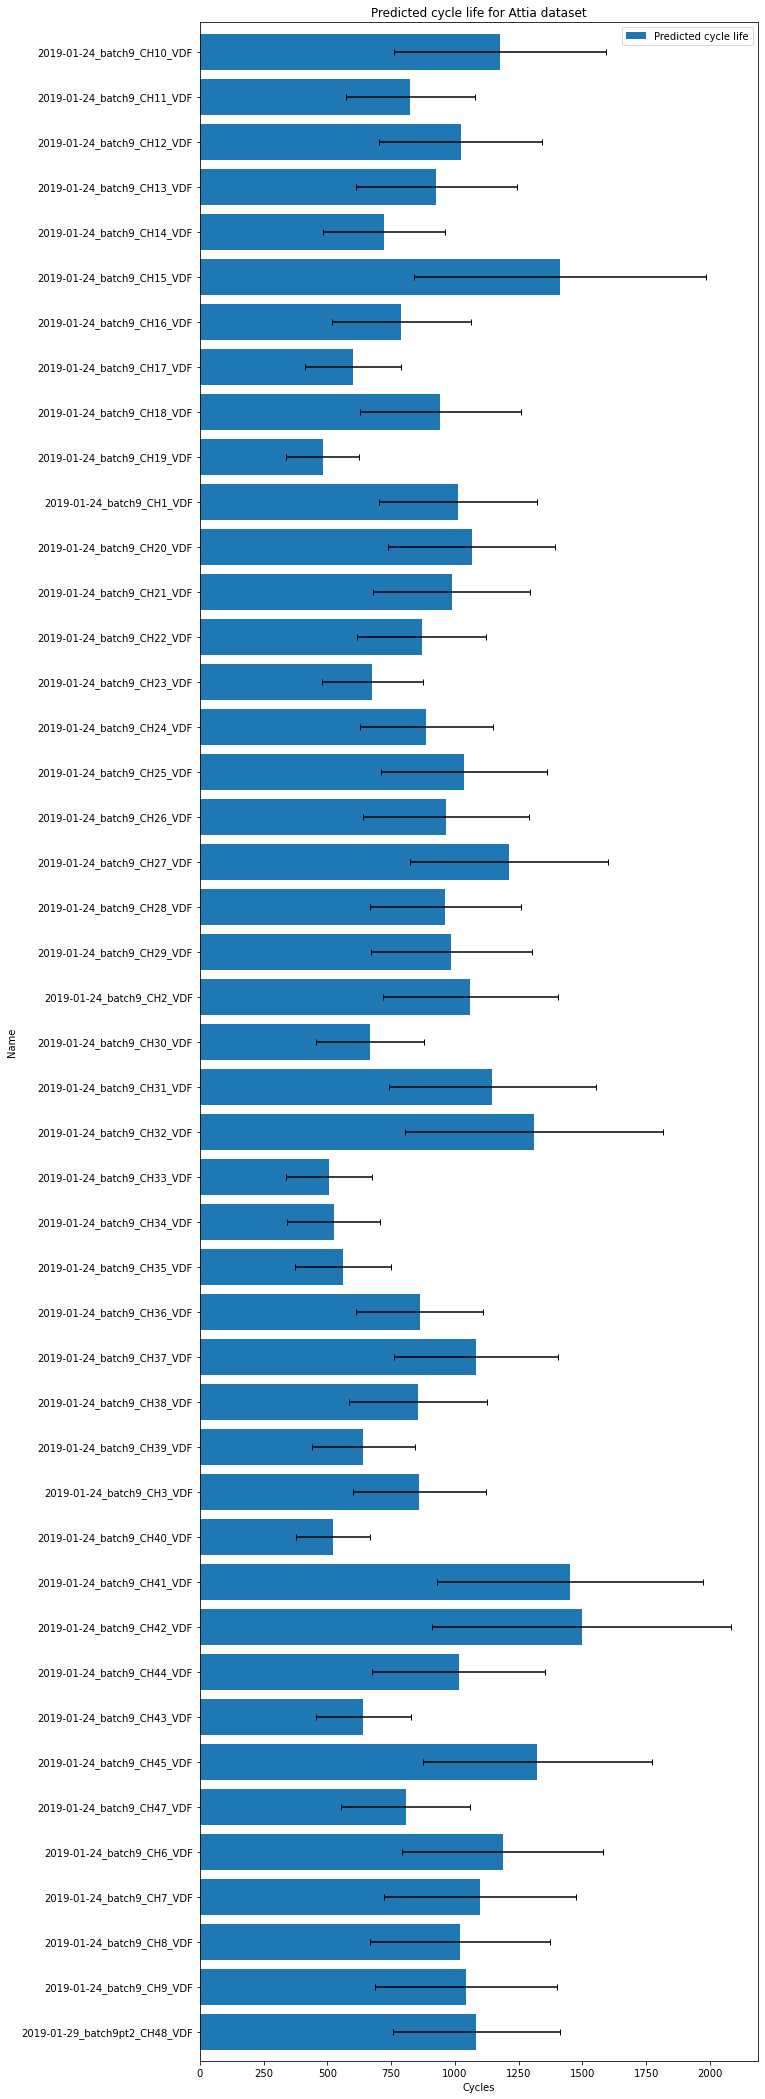

In [55]:
prediction_df_attia.plot.barh(xerr = en_attia_y_err, capsize = 3,figsize=(10, len(prediction_df_attia)/1.2), width = .8)
plt.xlabel('Cycles')
plt.title("Predicted cycle life for Attia dataset")
plt.show()

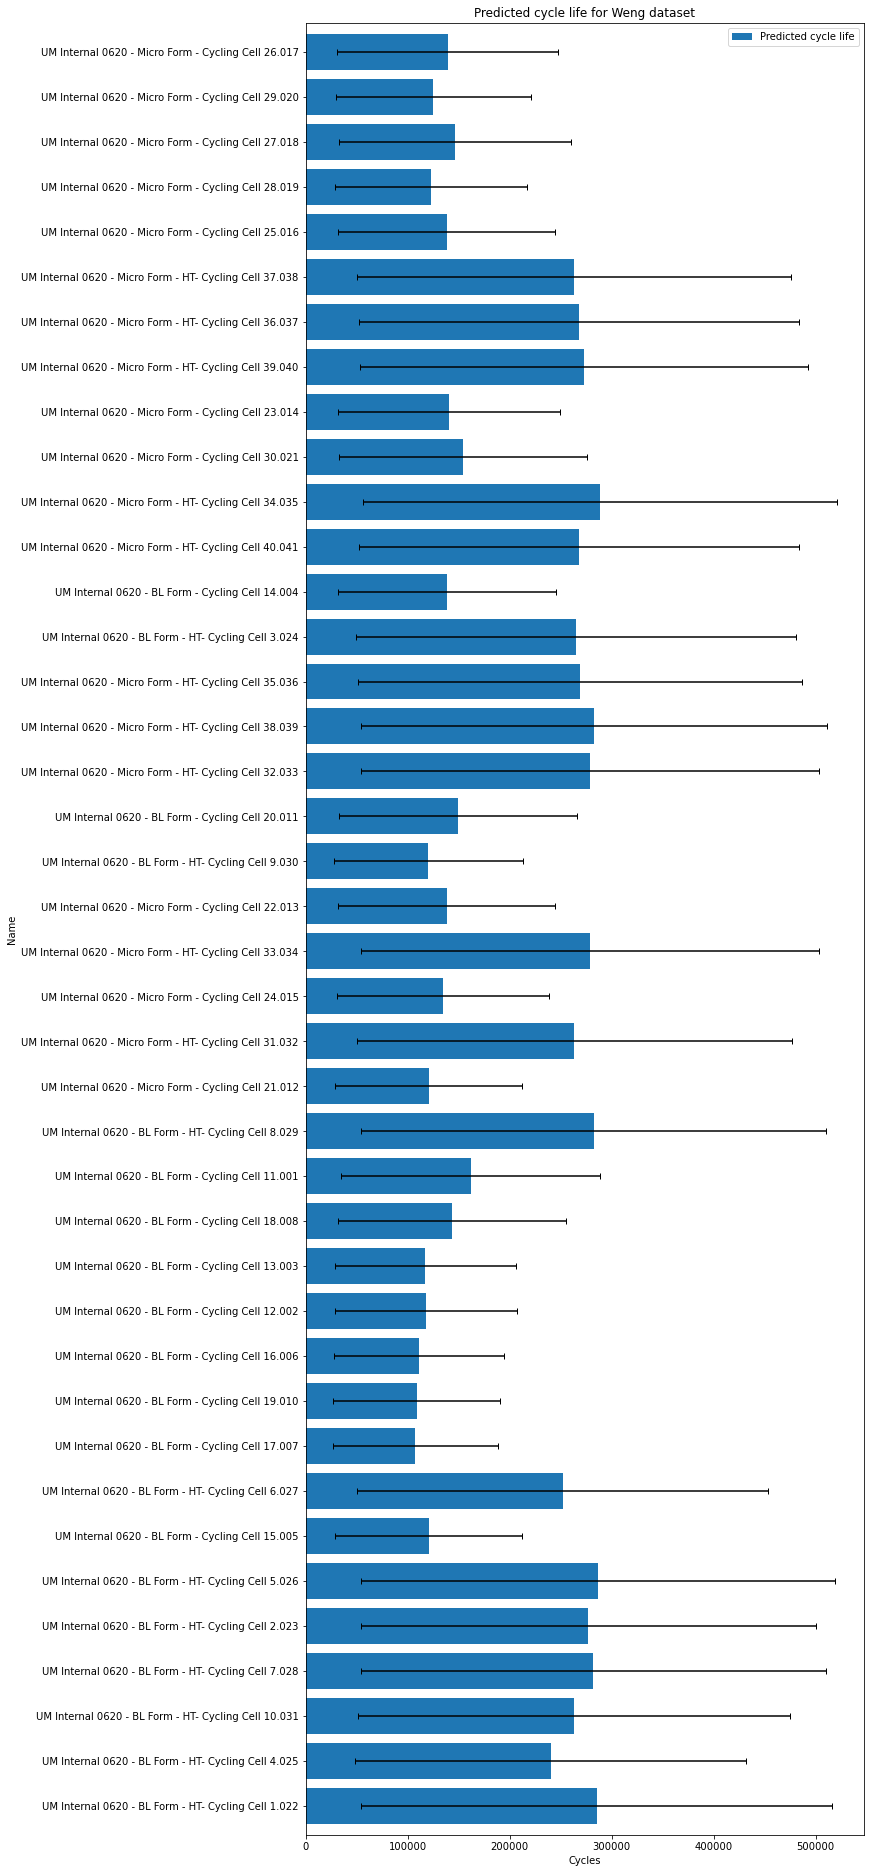

In [56]:
prediction_df_weng.plot.barh(xerr = en_weng_y_err, capsize = 3,figsize=(10, len(prediction_df_weng)/1.2), width = .8)
plt.xlabel('Cycles')
plt.title("Predicted cycle life for Weng dataset")
plt.show()

Let's also calculate the MAPE and RMSE values for comparison

In [57]:
attia_mape = 100*mean_absolute_percentage_error(np.power(10, y_attia), np.power(10, attia_predict))
attia_rmse = mean_squared_error(np.power(10, y_attia), np.power(10, attia_predict), squared=False)
print("Attia (LFP) mean absolute percentage error: ", attia_mape, "%")
print("Attia (LFP) root mean squared error: ", attia_rmse, " cycles")
weng_mape = 100*mean_absolute_percentage_error(np.power(10, y_weng), np.power(10, weng_predict))
weng_rmse = mean_squared_error(np.power(10, y_weng), np.power(10, weng_predict), squared=False)
print("Weng (NMC) mean absolute percentage error: ", weng_mape, "%")
print("Weng( (NMC) root mean squared error: ", weng_rmse, " cycles")

Attia (LFP) mean absolute percentage error:  22.71103768461477 %
Attia (LFP) root mean squared error:  222.89998132436162  cycles
Weng (NMC) mean absolute percentage error:  57461.5475229098 %
Weng( (NMC) root mean squared error:  210346.59768486922  cycles


## Summary
Uncertainty estimations are a critical part of building trustworth ML models whose limitations can be quantified. Many methods for uncertainty estimation exist, some of which are model-specific, while others are model-agnostic. The ultimate choice of uncertainty estimation method will depend on your model choice and goals. The MAPIE python package can be a powerful tool for measuring prediction intervals in the case when you are trying to use a model which does not inherently provide uncertainty information (aka any model that is not based on Bayesian statistics). Note that in some cases (e.g. as for Gaussian Process regression), it looks like MAPIE does not perform well; in this case GPR provides its own measure of uncertainty, which should be used instead.